# Wilfire risk to global forest carbon offset projects
This notebook allows you to explore a collection of 190 global forest carbon projects and their exposure to historical and future wildfire. The analysis is based off of Sust Global's 2023 ICLR paper 'Widespread increases in future wildfire risk to global forest carbon offset projects revealed by explainable AI'. https://www.climatechange.ai/papers/iclr2023/33

The analysis includes both satellite observed wildfires as well as modeled fires using Sust Global's wildfire AI model. The wildfire AI model is trained on 7 million global satellite wildfire observations. Validation results suggest substantial potential for high resolution, enhanced accuracy projections of global wildfire risk, and the model outperforms the U.S. National Center for Atmospheric Research’s leading fire model. 

The wildfire AI data provided has been smoothed with a 10-year moving average. **If interested in 1) Monthly/annual raw data 2) Precise map views of the results at high (300m-500m) spatial resolution, or 3) Expanded analysis at these projects or new projects, please contact us.** 

## Requirements
1. You will need to register with Sust Global to receive an API Key in order to access the wildfire AI data for the 190 projects. Your API Key is unique, and do not share it with others. 
2. Download the dataset 

### Import necessary packages

In [1]:
## If any packages are missing, pip install the packages via terminal or using the !{sys.executable} command below
import sys
#!{sys.executable} -m pip install --users geopandas matplotlib
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import requests

/home/jovyan/.local/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.7.2dev-CAPI-1.11.2 0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
#SUST_API_KEY = os.environ.get("SUST_API_KEY")
SUST_API_KEY = $YOUR_KEY$
PORTFOLIO = "ForestCarbonICLR"
PROJECT = "sust-forest-carbon"


### Helper function for accessing and cleaning data via Sust Global API

In [3]:
endpoints = {
    "portfolios": f"https://explorer.sustglobal.io/api/portfolios/",
    "assets"    : f"https://explorer.sustglobal.io/api/portfolios/{PORTFOLIO}/assets?rows=200",
    "summary"   : f"https://explorer.sustglobal.io/api/portfolios/{PORTFOLIO}/datasets/physical/summary?rows=200",
    "physical"  : f"https://explorer.sustglobal.io/api/portfolios/{PORTFOLIO}/datasets/physical/items?rows=200"
}


## Downloads data for desired risk into a dataframe using your API KEY 
def get_endpoint_as_df(endpoint_id, params={}, fetch_args={"print_pages": False}):
    
    headers = {
        "X-SustGlobal-APIKey": SUST_API_KEY, 
        "X-SustGlobal-Project": PROJECT
    }
    
    def fetch_with_pagination(endpoint_id, **kwargs):
        page = 1
        buff = []
        if endpoint_id == "portfolios":
            return pd.DataFrame(requests.get(f'{endpoints[endpoint_id]}', headers=headers).json())
        while True:
            response = requests.get(f'{endpoints[endpoint_id]}&page={page}', params=params, headers=headers).json()
            if len(response) > 0:
                if kwargs["print_pages"]:
                    print(page)
                buff = buff + response
                page += 1
            else:
                return pd.DataFrame(buff)
            
    res_df = fetch_with_pagination(endpoint_id, **fetch_args)
    if endpoint_id == "assets":
        if "geometry" in res_df.columns: # Polygons
            return gpd.GeoDataFrame(res_df.copy().drop("geometry", axis=1), geometry=res_df.geometry.apply(shape), crs="EPSG:4326")
        else: # Points
            return gpd.GeoDataFrame(res_df.copy(), geometry=gpd.points_from_xy(res_df.lng, res_df.lat), crs="EPSG:4326")
    elif endpoint_id == "physical":
        return pd.concat([
            res_df.drop('risk_exposure', axis=1),
            pd.DataFrame(list(res_df.risk_exposure))
        ], axis=1)
    else:
        return res_df
    



## Load forest carbon project information 

Columns are:

- 'Entity Name': Publicly available project code. VCS = Verra Carbon Standard, ACR = American Carbon Registry, CAR = Carbon Action Reserve 
- 'lat': approx centroid latitude of the polygon. Values in -90 to 90.
- 'lng': approx centroid longitude of the polygon. Values in -180 to 180.
- 'geometry': polygon geometry for each project. Can be either single polygons or multipolygons.


In [125]:
gdf = gpd.read_file('./data/sustglobal_ICLR_May_2023_devcenter.gpkg')
gdf

,Entity Name,lat,lng,geometry
0,ACR360,62.093133,-144.957140,"MULTIPOLYGON (((-144.12700 61.44520, -144.1270..."
1,ACR255,48.251012,-118.717251,"MULTIPOLYGON (((-118.43640 47.88090, -118.4389..."
2,ACR273,43.142460,-121.823847,"MULTIPOLYGON (((-121.00630 41.99830, -121.0063..."
3,CAR973,46.508794,-85.961377,"MULTIPOLYGON (((-86.85580 46.28220, -86.85580 ..."
4,ACR274,42.161733,-122.107387,"MULTIPOLYGON (((-122.22930 41.98250, -122.2291..."
...,...,...,...,...
185,VCS963,-8.971952,-69.493625,"POLYGON ((-69.43708 -9.00498, -69.44612 -8.997..."
186,VCS977,-2.569448,-51.116873,"MULTIPOLYGON (((-50.98288 -2.76712, -50.98376 ..."
187,VCS981,-2.037514,-51.294016,"MULTIPOLYGON (((-51.42412 -2.29440, -51.42230 ..."
188,VCS985,-7.723984,-75.948281,"MULTIPOLYGON (((-76.01407 -8.61581, -76.01434 ..."


In [126]:
print('Number of global carbon offset projects: ' + str(gdf.shape[0]))

Number of global carbon offset projects: 190


## Plot global carbon project locations

([], [])

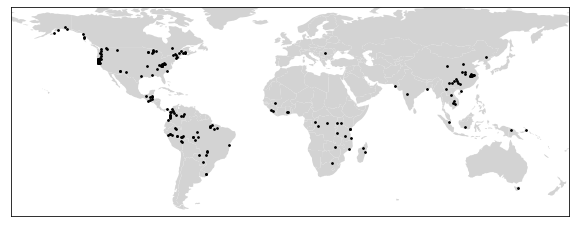

In [10]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
## See https://geopandas.org/en/stable/docs/user_guide/mapping.html for more examples
plot_gdf = gpd.GeoDataFrame(gdf.copy(), 
                            geometry = gpd.points_from_xy(gdf['lng'], gdf['lat']), 
                            crs = 'epsg:4326')
ax = plot_gdf.plot(color='black', markersize=3, zorder=2, figsize = (10,8))
world.plot(ax=ax, zorder=1, color = 'lightgrey')
ax.set_xlim(-180, 180)
ax.set_ylim(-60, 75)
plt.xticks([]) 
plt.yticks([]) 
 


# Fetch wildfire data via Sust Global API
The time series presented here for the wilfire AI model under different SSP climate scenarios has been smoothed with a 10-year moving average. **If interested in either 1) Monthly/annual raw data or 2) Precise map views of the results at high (300m-500m) spatial resolution, please contact us.**  

- 'indicator': one of ['unified_prob', 'obs_score'] for either the AI simulated fire probability or the satellite observed burn information
- 'scenario' one of ['ssp126', 'ssp245', 'ssp585] for the three climate scenarios
- 'measure' one of ['lb', 'mid', 'ub'] for lower bound (16th percentile), median, and upper bound (84th percentile)


In [116]:
wildfire_126 = get_endpoint_as_df("physical", params={
    'hazard': 'wildfire', 'indicator': 'unified_prob', 'scenario': 'ssp126', 'measure': 'mid'
})
wildfire_245 = get_endpoint_as_df("physical", params={
    'hazard': 'wildfire', 'indicator': 'unified_prob', 'scenario': 'ssp245', 'measure': 'mid'
})
wildfire_585 = get_endpoint_as_df("physical", params={
    'hazard': 'wildfire', 'indicator': 'unified_prob', 'scenario': 'ssp585', 'measure': 'mid'
})

## Annual observed wildfire within project boundary. Binary [1 = satellite detected burn; 0 = no detected burn]
wildfire_obs = get_endpoint_as_df("physical", params={
    'hazard': 'wildfire', 'indicator': 'obs_score'
})
## Sort observed wildfire dataframe to align with the ordering of the other dataframes
wildfire_obs = wildfire_obs.sort_values('portfolio_index', ignore_index = True)

In [117]:
wildfire_585

,portfolio_name,portfolio_index,entity_id,entity_name,hazard,indicator,scenario,measure,1980,1981,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,ForestCarbonICLR,0,,ACR360,wildfire,unified_prob,ssp585,mid,0.002917,0.002917,...,0.010777,0.011108,0.011569,0.011840,0.013239,0.014519,0.015794,0.016493,0.017964,0.020509
1,ForestCarbonICLR,1,,ACR255,wildfire,unified_prob,ssp585,mid,0.004323,0.004323,...,0.056723,0.059128,0.062935,0.064065,0.065235,0.064479,0.065994,0.066954,0.067951,0.069506
2,ForestCarbonICLR,2,,ACR273,wildfire,unified_prob,ssp585,mid,0.007014,0.007014,...,0.022745,0.023165,0.024339,0.024741,0.025072,0.025377,0.025884,0.026262,0.026703,0.027016
3,ForestCarbonICLR,3,,CAR973,wildfire,unified_prob,ssp585,mid,0.000164,0.000164,...,0.000879,0.001049,0.001136,0.001269,0.001335,0.001403,0.001411,0.001471,0.001508,0.001568
4,ForestCarbonICLR,4,,ACR274,wildfire,unified_prob,ssp585,mid,0.004070,0.004070,...,0.007832,0.007888,0.008069,0.008142,0.008221,0.008254,0.008296,0.008414,0.008476,0.008529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,ForestCarbonICLR,185,,VCS963,wildfire,unified_prob,ssp585,mid,0.003395,0.003395,...,0.012011,0.012090,0.012164,0.012400,0.012508,0.012558,0.012715,0.012877,0.012892,0.013071
186,ForestCarbonICLR,186,,VCS977,wildfire,unified_prob,ssp585,mid,0.001444,0.001444,...,0.002577,0.002597,0.002636,0.002639,0.002652,0.002666,0.002695,0.002710,0.002723,0.002734
187,ForestCarbonICLR,187,,VCS981,wildfire,unified_prob,ssp585,mid,0.001334,0.001334,...,0.002072,0.002084,0.002099,0.002101,0.002108,0.002117,0.002134,0.002141,0.002149,0.002154
188,ForestCarbonICLR,188,,VCS985,wildfire,unified_prob,ssp585,mid,0.000514,0.000514,...,0.001912,0.001948,0.001958,0.001985,0.002021,0.002046,0.002078,0.002135,0.002165,0.002192


In [118]:
wildfire_obs

,portfolio_name,portfolio_index,entity_id,entity_name,hazard,indicator,2001-01,2002-01,2003-01,2004-01,...,2013-01,2014-01,2015-01,2016-01,2017-01,2018-01,2019-01,2020-01,2021-01,2022-01
0,ForestCarbonICLR,0,,ACR360,wildfire,obs_score,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ForestCarbonICLR,1,,ACR255,wildfire,obs_score,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,ForestCarbonICLR,2,,ACR273,wildfire,obs_score,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,ForestCarbonICLR,3,,CAR973,wildfire,obs_score,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ForestCarbonICLR,4,,ACR274,wildfire,obs_score,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,ForestCarbonICLR,185,,VCS963,wildfire,obs_score,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
186,ForestCarbonICLR,186,,VCS977,wildfire,obs_score,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,ForestCarbonICLR,187,,VCS981,wildfire,obs_score,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188,ForestCarbonICLR,188,,VCS985,wildfire,obs_score,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Select a project_id for further examination


In [93]:
project_id = 'ACR255' # see 'Entity Name' column for list of valid options
gdf_project = gdf.loc[gdf['Entity Name'] == project_id]
gdf_project

,Entity Name,lat,lng,geometry
1,ACR255,48.251012,-118.717251,"MULTIPOLYGON (((-118.43640 47.88090, -118.4389..."


Text(0.5, 1.0, 'ACR255')

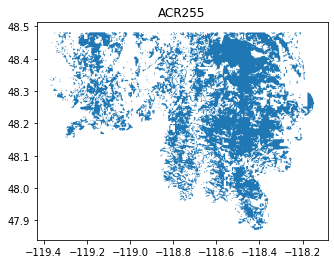

In [94]:
## Plot the project boundary
gdf_project.plot()
plt.title(project_id)

Text(0.5, 1.0, 'ACR255')

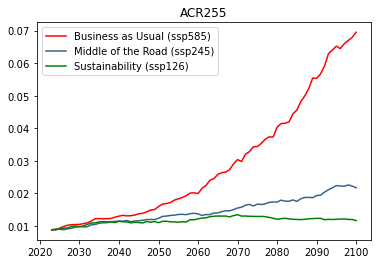

In [127]:
## Plot the smoothed time series projections of future change
start_year = 2023
end_year = 2100
x_years = range(start_year, end_year+1)

## Get the time series for the individual site
def df_to_ts(df, project_id, start_year, end_year):
    col_id_start = np.where(df.columns == str(start_year))[0][0]
    col_id_end = np.where(df.columns == str(end_year))[0][0]
    ts = df.iloc[np.where(df['entity_name'] == project_id)[0], col_id_start:(col_id_end+1)].values
    return ts

y_126 = df_to_ts(wildfire_126, project_id, start_year, end_year)
y_245 = df_to_ts(wildfire_245, project_id, start_year, end_year)
y_585 = df_to_ts(wildfire_585, project_id, start_year, end_year)

## Plotting calls
plt.plot(x_years, y_585.flatten(), color = 'red', label = 'Business as Usual (ssp585)')
plt.plot(x_years, y_245.flatten(), color = '#36648b', label = 'Middle of the Road (ssp245)')
plt.plot(x_years, y_126.flatten(), color = 'green', label = 'Sustainability (ssp126)')
plt.legend()
plt.title(project_id)

# Calculate validation ROC score for the wildfire AI model
Note that the output ROC curve and value here (0.75) is slightly different than in the ICLR publication (0.79) because here we are using smoothed data. The publication uses raw annual data and is therefore more precise.

In [121]:
val_start_year = 2010
val_end_year = 2021

## Subset satellite data for the validation period
col_id_start = np.where(wildfire_obs.columns == str(val_start_year)+'-01')[0][0]
col_id_end = np.where(wildfire_obs.columns == str(val_end_year)+'-01')[0][0]
val_obs = wildfire_obs.iloc[:, col_id_start:(col_id_end+1)].values

## Take the max across validation years. 1 = at least one fire has occured during period, 0 = no detected fires.
val_obs_binary = val_obs.max(axis = 1)

## Subset the fire AI data for the validation period
col_id_start = np.where(wildfire_585.columns == str(val_start_year))[0][0]
col_id_end = np.where(wildfire_585.columns == str(val_end_year))[0][0]
val_ai = wildfire_585.iloc[:, col_id_start:(col_id_end+1)].values

## Take the mean fire probability across validation years. Probability values between 0 and 1.
val_ai_mean = val_ai.mean(axis = 1)


In [122]:
print('Wildfire was observed at ' + str(np.sum(val_obs_binary == 1)) + ' of the projects during the validation period.')

Wildfire was observed at 67 of the projects during the validation period.


Text(0, 0.5, 'True Positive Rate')

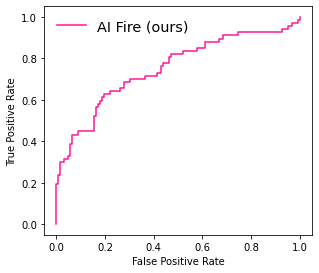

In [123]:
plt.figure(figsize = (4.8,4.2))
from sklearn.metrics import roc_auc_score, roc_curve
def plot_roc_curve(true_y, y_prob, label):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr, label = label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

fpr, tpr, thresholds = roc_curve(val_obs_binary, val_ai_mean)
plt.plot(fpr, tpr, label = 'AI Fire (ours)', color = 'deeppink')

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#add legend to plot
plt.legend(frameon = False,
           fontsize = 'x-large',) 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')



In [124]:
## The output ROC value here (0.75) is slightly different than in the ICLR publication (0.79) because here we are using smoothed data 
print('ROC score for Fire AI (Ours): ' + str(np.round(roc_auc_score(val_obs_binary, val_ai_mean),2)))


ROC score for Fire AI (Ours): 0.75
